In this notebook, we generate a common mask by combining Planck 2018 CMB lensing and Legacy Surveys DR9 footprints.

In [1]:
import healpy as hp
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

plt.style.use("ggplot")

Define $\ell_{\rm max}$ and `NSIDE` of the combined mask. 

In [2]:
NSIDE_OUT = 1024
LMAX_OUT = 3 * NSIDE_OUT - 1

#plotting params
fsize = (10, 7)
fs = 20

/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


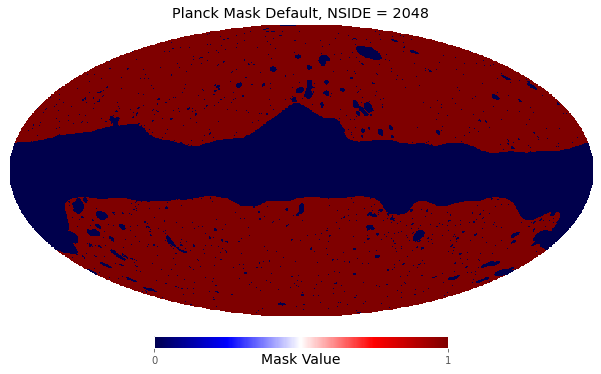

In [3]:
#cmb lensing mask
planck_mask_gal = hp.fitsfunc.read_map("../dat/planck-lensing-mask.fits") 
hp.mollview(planck_mask_gal, title = "Planck Mask Default, NSIDE = 2048", unit = 'Mask Value', cmap = 'seismic')

Text(0, 0.5, '$C^{\\rm mask}_{\\ell}$')

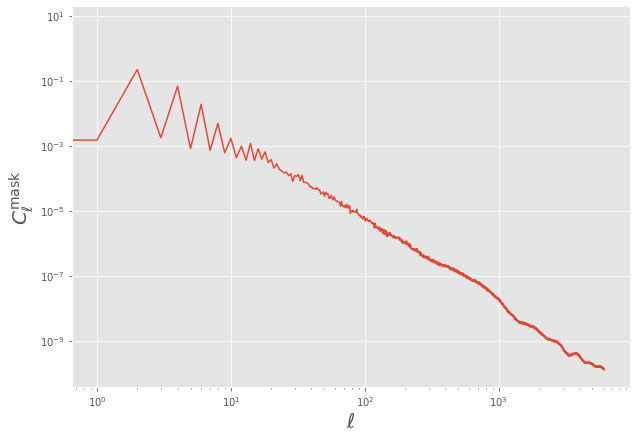

In [4]:
#calculate power spectrum of raw mask
cl_planck_mask_gal = hp.anafast(planck_mask_gal, pol = False)

plt.figure(figsize = fsize)
plt.loglog(np.arange(3*2048), cl_planck_mask_gal)
plt.xlabel(r"$\ell$", fontsize = fs)
plt.ylabel(r"$C^{\rm mask}_{\ell}$", fontsize = fs)

## Apodize according to Equation 83 of Singh 2021

Text(0, 0.5, '$b_{\\ell}$')

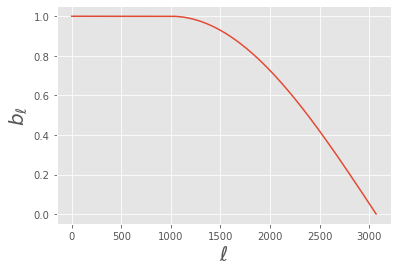

In [5]:
#define and visualize apodization function

def blcos(ell_array, ell_min = 1000, ell_max = LMAX_OUT):
    blcos_array = np.zeros(ell_array.shape)
    blcos_array[ell_array <= ell_min] = 1.
    blcos_array[(ell_array > ell_min) & (ell_array < ell_max)] = \
    np.cos(np.pi/2 * (ell_array[(ell_array > ell_min) & (ell_array < ell_max)] - ell_min)/(ell_max - ell_min))
    
    return blcos_array

blcos_array = blcos(np.arange(0, LMAX_OUT))
plt.plot(blcos_array)
plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylabel(r'$b_{\ell}$', fontsize = 20)

In [6]:
#calculate planck a_lms
planck_mask_gal_alms = hp.map2alm(planck_mask_gal, lmax=LMAX_OUT, pol=False)

#multiply a_lms with apodizing function
planck_mask_gal_alms_apodized = hp.almxfl(planck_mask_gal_alms, blcos_array)
planck_mask_gal_apodized = hp.alm2map(planck_mask_gal_alms_apodized, nside = 2048) #Planck native resolution

#min-max normalization ##IS THIS ESSENTIAL?
#planck_mask_gal_apodized_norm = (planck_mask_gal_apodized - planck_mask_gal_apodized.min())/\
#(planck_mask_gal_apodized.max() - planck_mask_gal_apodized.min())

/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


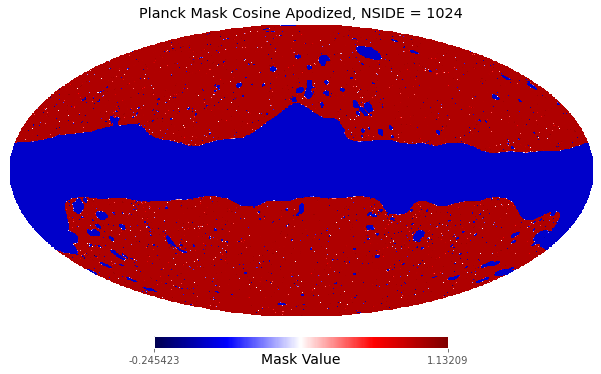

In [7]:
#visualize normalized map
hp.mollview(planck_mask_gal_apodized, title='Planck Mask Cosine Apodized, NSIDE = 1024', 
            unit='Mask Value', cmap = 'seismic')

Difference between apodized map and original map

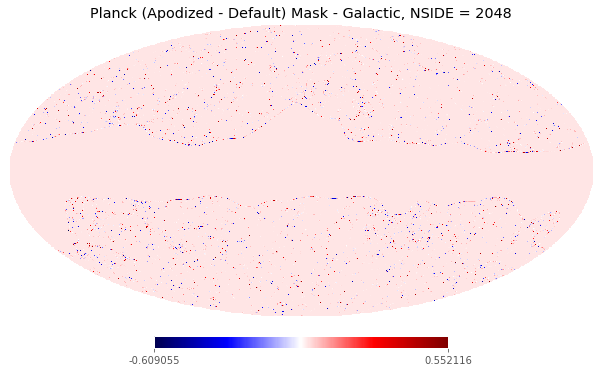

In [8]:
hp.mollview(planck_mask_gal_apodized - planck_mask_gal, cmap = 'seismic', 
            title = "Planck (Apodized - Default) Mask - Galactic, NSIDE = 2048")

Compare power spectra of original mask map and apodized map

In [9]:
cl_planck_mask_gal_apodized = hp.alm2cl(planck_mask_gal_alms_apodized)

Text(0, 0.5, '$\\frac{C^{\\rm apodized}_{\\ell}}{C^{\\rm raw}_{\\ell}}$')

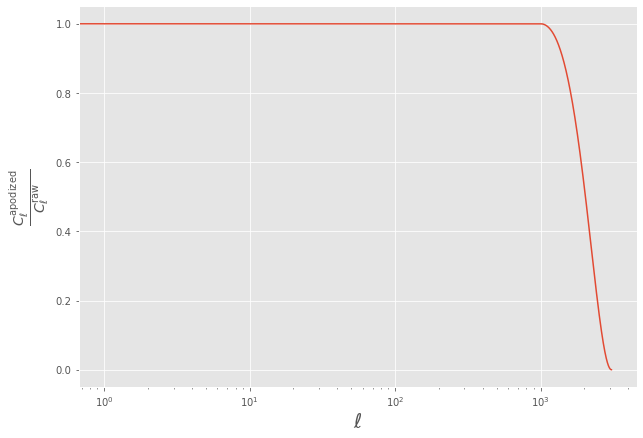

In [10]:
plt.figure(figsize=(10, 7))
plt.semilogx(cl_planck_mask_gal_apodized/cl_planck_mask_gal[:LMAX_OUT+1])
plt.xlabel("$\ell$", fontsize = 20)
plt.ylabel(r"$\frac{C^{\rm apodized}_{\ell}}{C^{\rm raw}_{\ell}}$", fontsize = 20)

Rotate apodized mask in $a_{\ell m}$ space

In [11]:
#rotate from Eq. Coord. to Gal. Coord to match Planck 
r = hp.Rotator(coord=['G','C']) #define rotator class from Eq. Coord. to Gal. Coord
planck_mask_eq_alms_apodized = r.rotate_alm(planck_mask_gal_alms_apodized)

/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


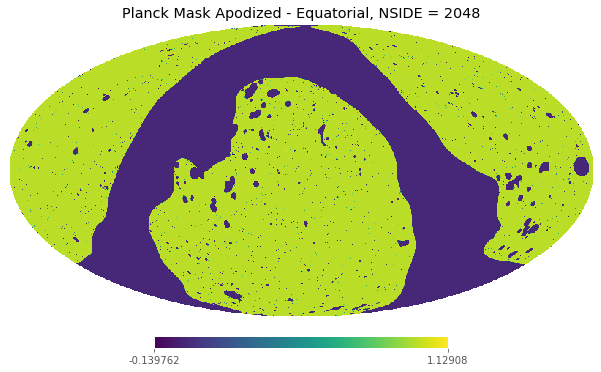

In [12]:
hp.mollview(hp.alm2map(planck_mask_eq_alms_apodized, nside=2048), 
            title = "Planck Mask Apodized - Equatorial, NSIDE = 2048")

In [13]:
cl_planck_mask_eq_apodized = hp.alm2cl(planck_mask_eq_alms_apodized)

<ipython-input-14-b01f10627735>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(cl_planck_mask_eq_apodized/cl_planck_mask_gal_apodized)


Text(0.5, 1.0, 'Ratio of power spectra of apodized mask maps')

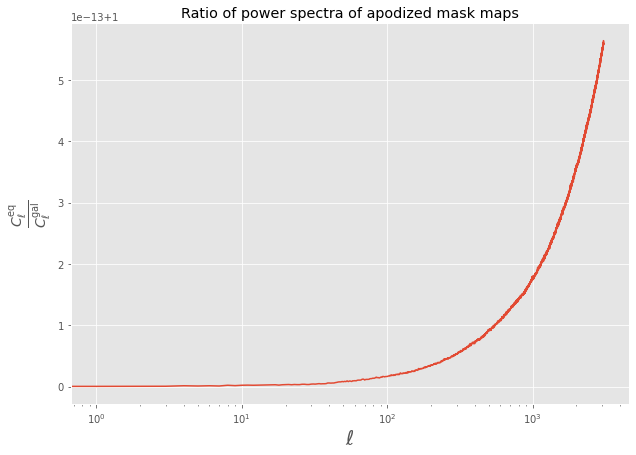

In [14]:
plt.figure(figsize=fsize)
plt.semilogx(cl_planck_mask_eq_apodized/cl_planck_mask_gal_apodized)
plt.xlabel("$\ell$", fontsize = fs)
plt.ylabel(r"$\frac{C^{\rm eq}_{\ell}}{C^{\rm gal}_{\ell}}$", fontsize = fs)
plt.title("Ratio of power spectra of apodized mask maps")

**Observation:** Rotation is good up to machine precision!

Generate apodized equatorial mask to `NSIDE = 1024`

/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


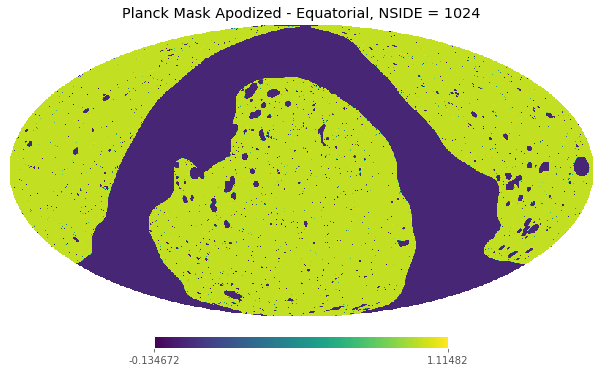

In [15]:
planck_mask_eq_apodized_1024 = hp.alm2map(planck_mask_eq_alms_apodized, nside=NSIDE_OUT)
hp.mollview(planck_mask_eq_apodized_1024, title = "Planck Mask Apodized - Equatorial, NSIDE = 1024")

<ipython-input-16-fb9be1a81427>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(cl_planck_mask_eq_apodized_1024/cl_planck_mask_gal_apodized)


Text(0.5, 1.0, 'Ratio of power spectra of apodized maps')

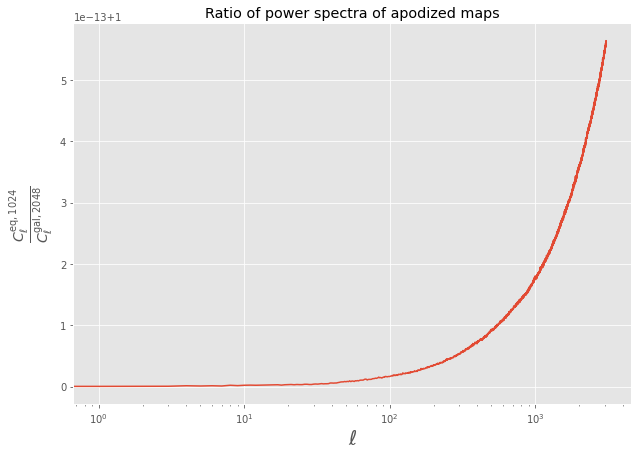

In [16]:
cl_planck_mask_eq_apodized_1024 = hp.alm2cl(planck_mask_eq_alms_apodized, lmax_out=LMAX_OUT)

plt.figure(figsize=fsize)
#plt.loglog(cl_eq_apodized_1024[:NSIDE_OUT]/cl_gal_apodized[:NSIDE_OUT])
plt.semilogx(cl_planck_mask_eq_apodized_1024/cl_planck_mask_gal_apodized)
plt.xlabel("$\ell$", fontsize = 20)
plt.ylabel(r"$\frac{C^{\rm eq, 1024}_{\ell}}{C^{\rm gal, 2048}_{\ell}}$", fontsize = 20)
plt.title("Ratio of power spectra of apodized maps")

Shift the apodized Planck mask by a scalar value such that the lowest value is $0$. 

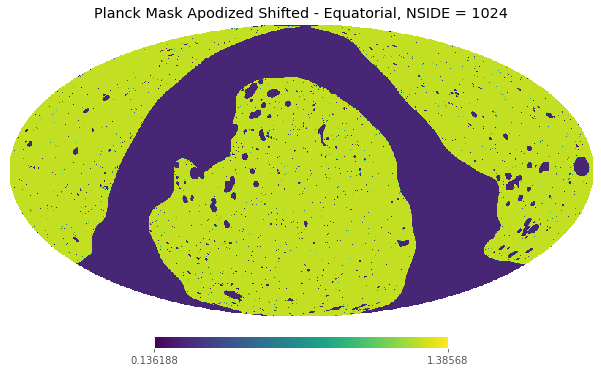

In [21]:
planck_mask_eq_apodized_1024_shifted = planck_mask_eq_apodized_1024 + np.abs(np.min(planck_mask_eq_apodized_1024))
hp.mollview(planck_mask_eq_apodized_1024_shifted, 
            title = "Planck Mask Apodized Shifted - Equatorial, NSIDE = 1024")

<ipython-input-40-0f9c9d01b652>:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogx((cl_planck_mask_eq_apodized_1024_shifted/cl_planck_mask_gal_apodized)[10:NSIDE_OUT])


Text(0.5, 1.0, 'Ratio of power spectra of apodized maps')

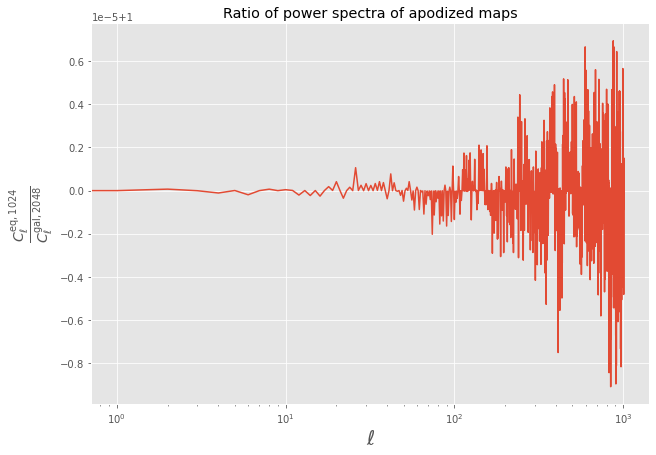

In [40]:
#cl_planck_mask_eq_apodized_1024_shifted = hp.anafast(planck_mask_eq_apodized_1024_shifted, pol = False)

plt.figure(figsize=fsize)
#plt.loglog(cl_eq_apodized_1024[:NSIDE_OUT]/cl_gal_apodized[:NSIDE_OUT])
plt.semilogx((cl_planck_mask_eq_apodized_1024_shifted/cl_planck_mask_gal_apodized)[10:NSIDE_OUT])
plt.xlabel("$\ell$", fontsize = 20)
plt.ylabel(r"$\frac{C^{\rm eq, 1024}_{\ell}}{C^{\rm gal, 2048}_{\ell}}$", fontsize = 20)
plt.title("Ratio of power spectra of apodized maps")

In [41]:
np.save("../dat/planck-lensing-mask-eq-1024.npy", planck_mask_eq_apodized_1024_shifted, allow_pickle=False)

## Combine Planck and ELG masks in $a_{\ell m}$ space

### Derivation

Let, $m_{\rm Planck}$ and $m_{ELG}$ denote Planck and ELG masks in real space respectively. We are interested in deriving the quantity $m_{\rm comb}$, i.e. the combined mask. In real space, this quantity is given by:

\begin{equation}
m_{\rm comb} = \min(m_{\rm Planck}, m_{ELG})
\end{equation}

Now, signal in real space can be expressed in terms of spherical harmonics via (in Einstein Notation):

\begin{equation}
m_{\rm Planck} (\theta, \phi) = a^{\rm Planck}_{\ell m} Y^{\ell m} (\theta, \phi) \\
m_{\rm ELG} (\theta, \phi) = a^{\rm ELG}_{\ell m} Y^{\ell m} (\theta, \phi)
\end{equation}

Plugging these values back into the first equation:

\begin{align}
m_{\rm comb} &= \min(m_{\rm Planck}, m_{ELG}) \\
&= \min(a^{\rm Planck}_{\ell m} Y^{\ell m}, a^{\rm ELG}_{\ell m} Y^{\ell m}) \\
&= \min(a^{\rm Planck}_{\ell m}, a^{\rm ELG}_{\ell m}) Y^{\ell m}
\end{align}

Now, signal in spherical harmonic space can be expressed in terms of real space signal via:

\begin{align}
a_{\ell m}^{\rm comb} &= \int m_{\rm comb} Y^{\ell m} d\Omega \\
&= \int \min(a^{\rm Planck}_{\ell m}, a^{\rm ELG}_{\ell m}) Y^{\ell m} Y^{\ell m} d\Omega \\
&= \min(a^{\rm Planck}_{\ell m}, a^{\rm ELG}_{\ell m}) \int [Y^{\ell m} (\theta, \phi)]^2 d\Omega \\
&= \min(a^{\rm Planck}_{\ell m}, a^{\rm ELG}_{\ell m}) \delta^{\ell \ell} \delta^{mm} \\
&= \min(a^{\rm Planck}_{\ell m}, a^{\rm ELG}_{\ell m})
\end{align}

Thus, we can calculate the combined mask in spherical harmonic space easily.

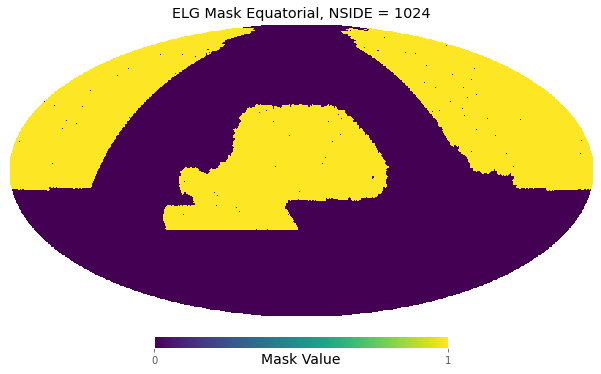

In [17]:
elg_mask_eq = np.load("../../imaging-sys-covariance/dat/elg_ran1024.npy")
elg_mask_eq[elg_mask_eq > 0] = 1
hp.mollview(elg_mask_eq, title = 'ELG Mask Equatorial, NSIDE = 1024', unit='Mask Value')

/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


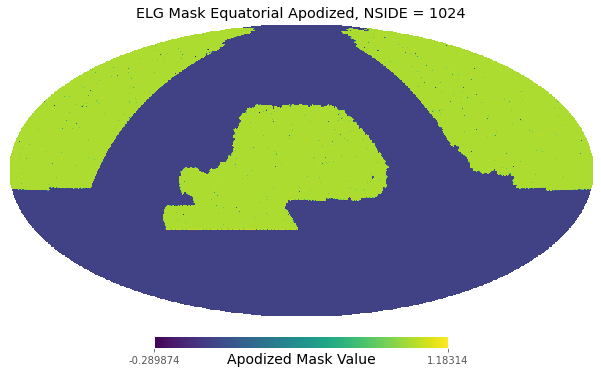

In [18]:
#calculate ELG a_lms
elg_mask_eq_alms = hp.map2alm(elg_mask_eq, lmax=LMAX_OUT, pol=False)

#multiply a_lms with apodizing function
elg_mask_eq_alms_apodized = hp.almxfl(elg_mask_eq_alms, blcos_array)
elg_mask_eq_apodized = hp.alm2map(elg_mask_eq_alms_apodized, nside = NSIDE_OUT)

hp.mollview(elg_mask_eq_apodized, title = 'ELG Mask Equatorial Apodized, NSIDE = 1024', 
            unit = 'Apodized Mask Value')

Visualize both masks together

In [39]:
np.mean(planck_mask_eq_apodized_1024)

0.6706295912641843

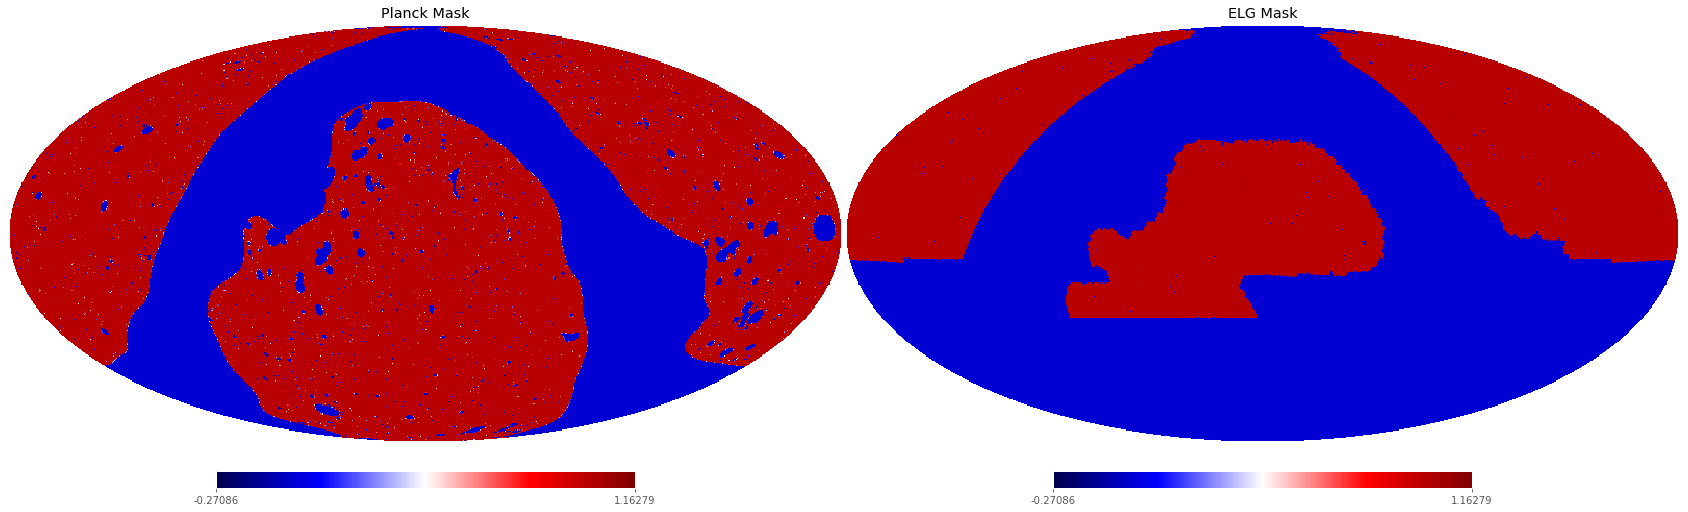

In [18]:
fg, ax = plt.subplots(ncols=2, figsize=(30, 10))
fg.subplots_adjust(wspace=0.0)

plt.sca(ax[0])
hp.mollview(planck_mask_eq_apodized_1024, title = "Planck Mask", hold = True, cmap = 'seismic',
           max = np.maximum(planck_mask_eq_apodized_1024.max(), elg_mask_eq.max()),
           min = np.minimum(planck_mask_eq_apodized_1024.min(), elg_mask_eq.min()))

plt.sca(ax[1])
hp.mollview(elg_mask_eq, title = "ELG Mask", hold = True, cmap = 'seismic',
           max = np.maximum(planck_mask_eq_apodized_1024.max(), elg_mask_eq.max()),
           min = np.minimum(planck_mask_eq_apodized_1024.min(), elg_mask_eq.min()))

Check whether most values are concentrated at $0$ and $1$.

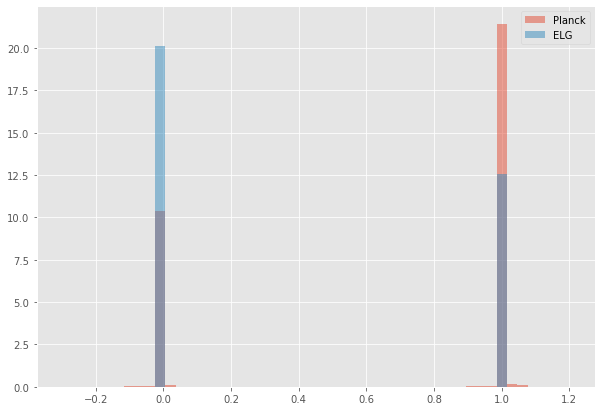

In [19]:
plt.figure(figsize=fsize)
plt.hist(planck_mask_eq_apodized_1024, bins = np.linspace(-.3, 1.2, 50), 
         density=True, label = 'Planck', alpha = 0.5);
plt.hist(elg_mask_eq, bins = np.linspace(-.3, 1.2, 50), 
         density=True, label = 'ELG', alpha = 0.5);
plt.legend(loc = 'best')

**Problem:** How to calculate mask in spherical harmonic space? 

/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


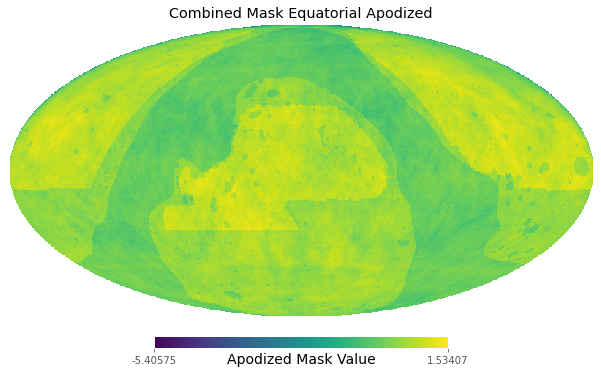

In [48]:
#calculate combined mask in spherical harmonic space and visualize
#comb_mask_eq_alms_apodized = np.minimum(elg_mask_eq_alms_apodized, planck_mask_eq_alms_apodized)
comb_mask_eq_alms_apodized = np.minimum(elg_mask_eq_alms_apodized, planck_mask_eq_alms_apodized)

hp.mollview(hp.alm2map(comb_mask_eq_alms_apodized, nside=NSIDE_OUT), 
            title = 'Combined Mask Equatorial Apodized', unit= 'Apodized Mask Value')

In [75]:
#calculate combined map in harmonic space
tmpcombMap = hp.alm2map(comb_mask_eq_alms_apodized, nside=NSIDE_OUT)

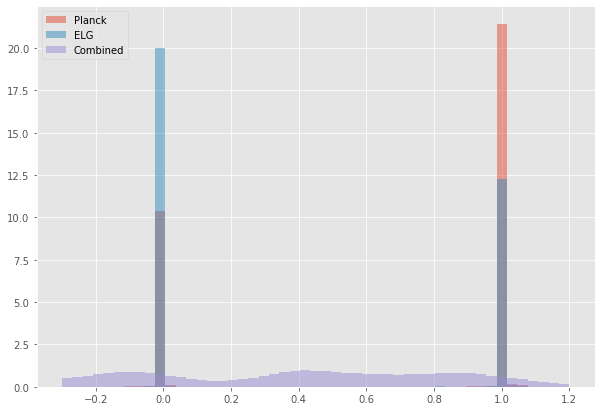

In [76]:
plt.figure(figsize=fsize)
plt.hist(planck_mask_eq_apodized_1024, bins = np.linspace(-.3, 1.2, 50), 
         density=True, label = 'Planck', alpha = 0.5);
plt.hist(elg_mask_eq_apodized, bins = np.linspace(-.3, 1.2, 50), 
         density=True, label = 'ELG', alpha = 0.5);
plt.hist(tmpcombMap, bins = np.linspace(-.3, 1.2, 50), 
         density=True, label = 'Combined', alpha = 0.5);
plt.legend(loc = 'best')

**Observation:** Combined map looks weird?

In [19]:
#combine mask in real space
combined_mask_eq_1024 = np.minimum(planck_mask_eq_apodized_1024, elg_mask_eq)

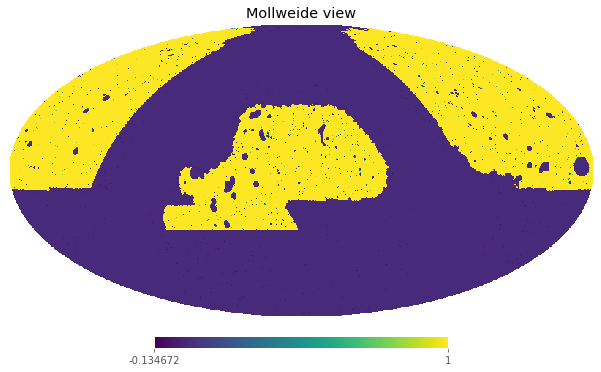

In [20]:
hp.mollview(combined_mask_eq_1024)

In [21]:
cl_combined_mask_eq_1024 = hp.anafast(combined_mask_eq_1024, lmax=LMAX_OUT, pol=False)
cl_elg_mask_eq = hp.anafast(elg_mask_eq, lmax=LMAX_OUT, pol=False)

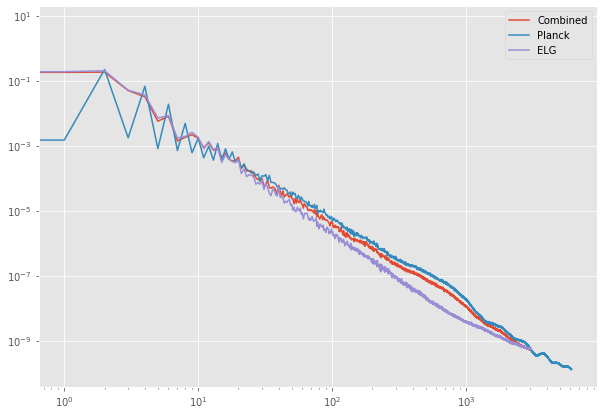

In [23]:
plt.figure(figsize = fsize)
plt.loglog(cl_combined_mask_eq_1024, label = 'Combined')
plt.loglog(cl_planck_mask_gal, label = 'Planck')
plt.loglog(cl_elg_mask_eq, label = 'ELG')
plt.legend(loc = 'best')

In [24]:
np.mean(combined_mask_eq_1024)

0.36772718029816365

In [26]:
tmpmap = deepcopy(combined_mask_eq_1024)
tmpmap[tmpmap >= 0.95] = 1
tmpmap[tmpmap < 0.95] = 0

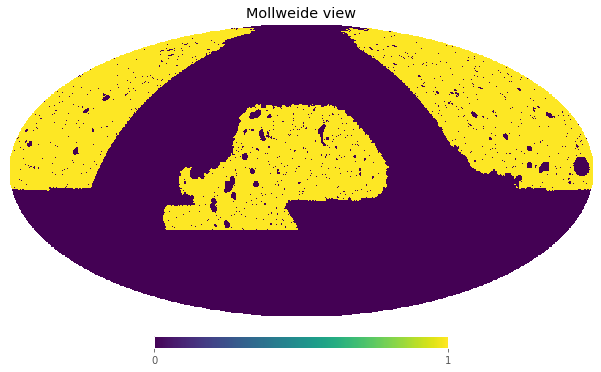

In [27]:
hp.mollview(tmpmap)

In [28]:
np.mean(tmpmap)

0.36560781796773273

In [29]:
cl_tmpmap = hp.anafast(tmpmap, lmax = LMAX_OUT, pol = False)

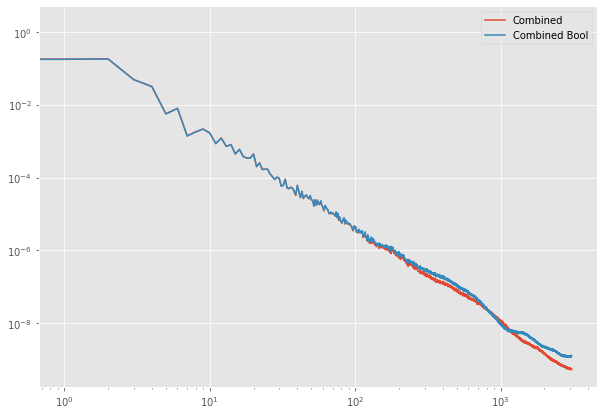

In [31]:
plt.figure(figsize = fsize)
plt.loglog(cl_combined_mask_eq_1024, label = 'Combined')
#plt.loglog(cl_planck_mask_gal, label = 'Planck')
#plt.loglog(cl_elg_mask_eq, label = 'ELG')
plt.loglog(cl_tmpmap, label = 'Combined Bool')
plt.legend(loc = 'best')

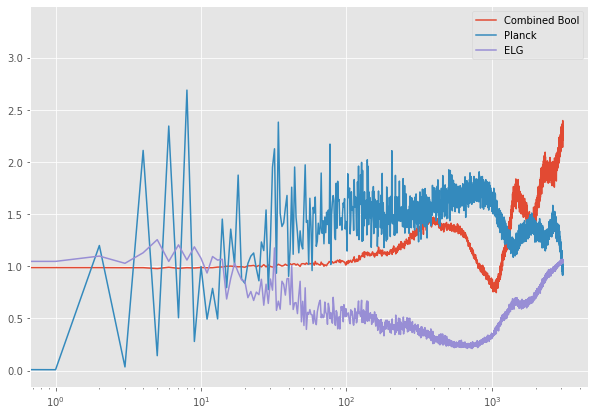

In [37]:
plt.figure(figsize = fsize)
plt.semilogx(cl_tmpmap/cl_combined_mask_eq_1024, label = 'Combined Bool')
plt.semilogx(cl_planck_mask_gal[:LMAX_OUT+1]/cl_combined_mask_eq_1024, label = 'Planck')
plt.semilogx(cl_elg_mask_eq/cl_combined_mask_eq_1024, label = 'ELG')
#plt.loglog(cl_tmpmap, label = 'Combined Bool')
plt.legend(loc = 'best')

In [38]:
tmpmap.sum()/tmpmap.size

0.36560781796773273

In [116]:
ii = 10

In [117]:
elg_mask_eq_alms_apodized[ii]

(-0.06484352708883598+0j)

In [118]:
planck_mask_eq_alms_apodized[ii]

(-0.010308981041548204+0j)

In [119]:
tmpcombMask_alm[ii]

(-0.05153860928088763+0j)

In [120]:
np.minimum(elg_mask_eq_alms_apodized[ii], planck_mask_eq_alms_apodized[ii])

(-0.06484352708883598+0j)

## f$_{\rm sky}$ statistics for each mask

ELGs

In [23]:
elg_mask_eq_apodized[elg_mask_eq_apodized > 0.].size/elg_mask_eq_apodized.size

0.6925705273946127

In [24]:
elg_mask_eq[elg_mask_eq > 0].size/elg_mask_eq.size

0.38390517234802246

Planck

In [25]:
planck_mask_eq_apodized_1024[planck_mask_eq_apodized_1024 > 0].size/planck_mask_eq_apodized_1024.size

0.8362769285837809

In [26]:
planck_mask_gal[planck_mask_gal > 0].size/planck_mask_gal.size

0.670629620552063

Combined

In [27]:
tmpcombMask[tmpcombMask > 0].size/tmpcombMask.size

0.6070423126220703

In [28]:
tmpcombMask[tmpcombMask > 0.5].size/tmpcombMask.size

0.3684261639912923

### Save combined mask

In [175]:
tmptmp = (tmpcombMask - tmpcombMask.min())/(tmpcombMask.max() - tmpcombMask.min())

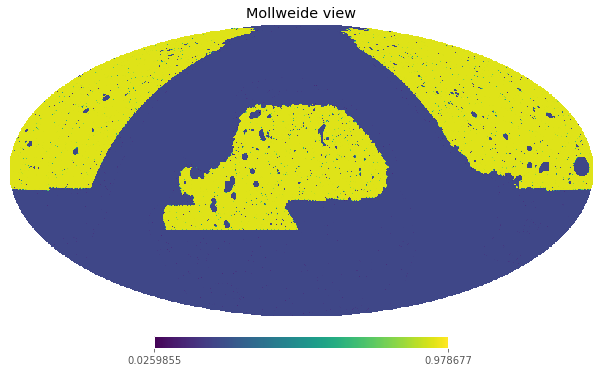

In [176]:
hp.mollview(tmptmp)

In [177]:
tmptmpcl = hp.anafast(tmptmp, pol = False, lmax = LMAX_OUT)
tmpcombMaskcl = hp.anafast(tmpcombMask, pol = False, lmax = LMAX_OUT)

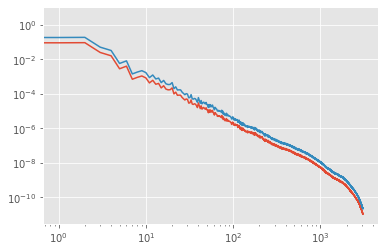

In [178]:
plt.loglog(tmptmpcl)
plt.loglog(tmpcombMaskcl)

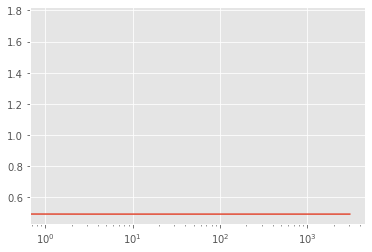

In [179]:
plt.semilogx(tmptmpcl/tmpcombMaskcl)

In [181]:
tmptmpcl/tmpcombMaskcl

array([1.76129877, 0.49330672, 0.49330672, ..., 0.49330672, 0.49335166,
       0.49330672])

In [29]:
np.save("../dat/planck-dr8-commonmask.npy", tmpcombMask, allow_pickle=False)

In [30]:
tmpcombMask.sum()/tmpcombMask.size

0.3674577939994892